# Assignment 2 - Bayesian Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score

In [3]:
import pymc3 as pm
from theano import shared

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. EDA

In [8]:
df = pd.read_csv('data/spambase.data', header=None)
print(df.shape)
df.head()

(4601, 58)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [9]:
df.columns = [
    line[:-1]
    for line in open('spambase-cols.txt', 'r')
]

In [10]:
# features with highest correlations

corr = df.corr()
corr_sorted = corr['spam'].sort_values()

print(corr_sorted.iloc[:5])
print(corr_sorted.iloc[-5:])

word_freq_hp       -0.256723
word_freq_hpl      -0.232968
word_freq_george   -0.183404
word_freq_1999     -0.178045
word_freq_labs     -0.171095
Name: spam, dtype: float64
char_freq_$         0.323629
word_freq_remove    0.332117
word_freq_000       0.334787
word_freq_your      0.383234
spam                1.000000
Name: spam, dtype: float64


In [11]:
df['spam'].mean()

0.39404477287546186

## 2. Baseline classification using frequentist models

In [8]:
# simple logistic regression

scaler = ColumnTransformer([('minmax-scaler', 
                              MinMaxScaler(),
                             ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']
                            )], remainder='passthrough')

model = Pipeline([('scaler', scaler), ('logmodel', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(df[[x for x in df.columns if x != 'spam']], df['spam'], random_state=42)

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


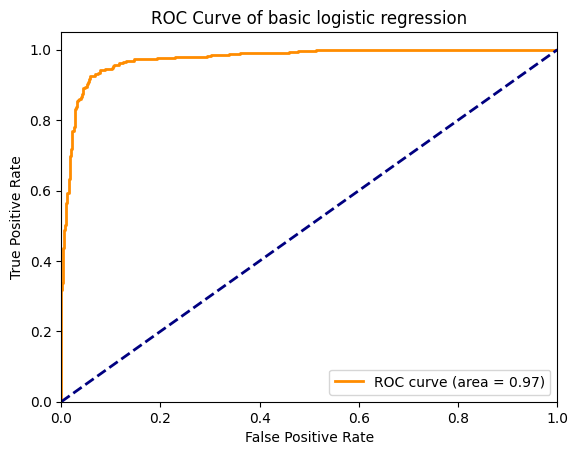

In [10]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of basic logistic regression")
plt.legend(loc="lower right")
plt.show()

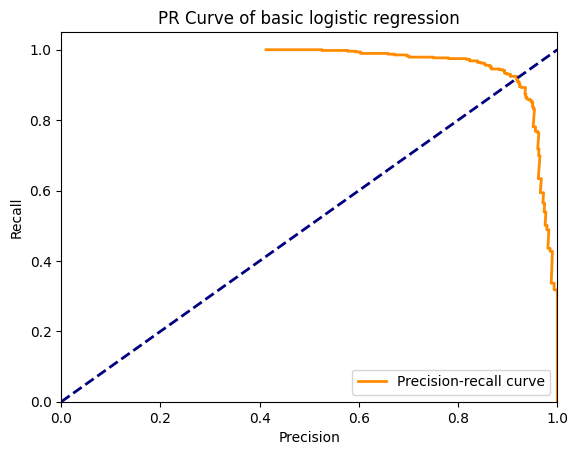

In [11]:
prc, rec, _ = precision_recall_curve(y_test, y_pred)

plt.figure()
lw = 2
plt.plot(
    prc,
    rec,
    color="darkorange",
    lw=lw,
    label="Precision-recall curve",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve of basic logistic regression")
plt.legend(loc="lower right")
plt.show()

In [12]:
# simple feature importance

coeffs = model['logmodel'].coef_

In [13]:
df_coef = pd.DataFrame.from_dict({
        'feature': X_train.columns.values,
        'coef': coeffs[0,:]
    }).sort_values(by='coef')

df_coef.head()

,feature,coef
29,word_freq_labs,-3.680719
46,word_freq_table,-1.842595
27,word_freq_650,-1.718950
50,char_freq_[,-1.452746
44,word_freq_re,-1.447906


<AxesSubplot: xlabel='coef', ylabel='feature'>

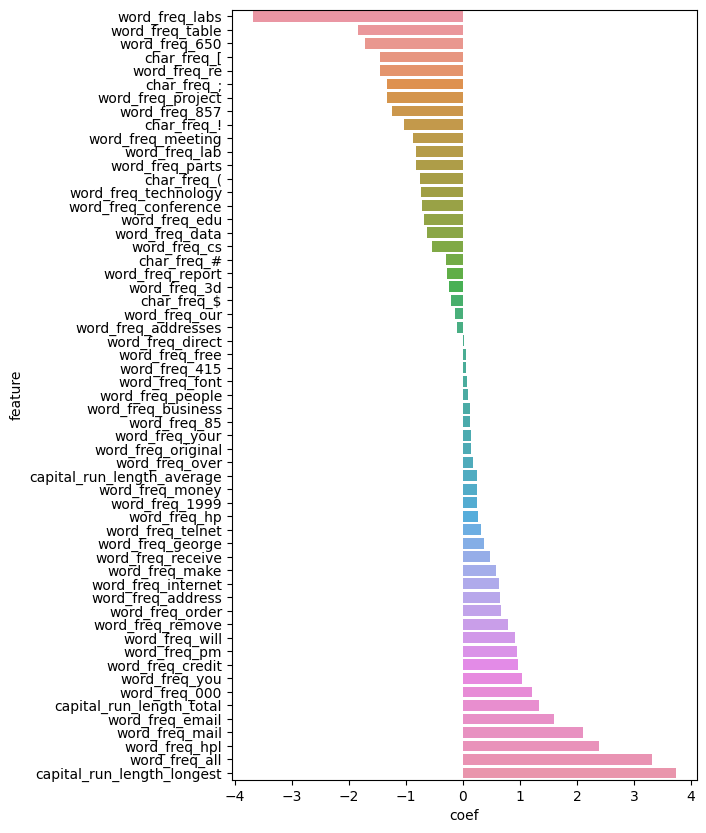

In [14]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(df_coef, y='feature', x='coef', ax=ax)

## 3. Baseline classification using Bayesian Logistic Regression

In [12]:
# manually

def create_model(X_train, y_train):
    with pm.Model() as log_model:
        lr_input = pm.Data("lr_input", X_train)
        lr_output = pm.Data("lr_output", y_train)

        # Weights from input to output
        lr_weights = pm.Normal(
            "lr_weights",
            0,
            sigma=1,
            shape=(X_train.shape[1],),
            testval=np.random.randn(X_train.shape[1]).astype(float)
        )

        # Build logistic model using sigmoid activation function
        act_out = pm.math.sigmoid(pm.math.dot(lr_input, lr_weights))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=lr_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
        )
    return log_model

In [15]:
scaler = ColumnTransformer([('minmax-scaler', 
                              MinMaxScaler(),
                             ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']
                            )], remainder='passthrough')

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[[x for x in df.columns if x != 'spam']], df['spam'], random_state=42)
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [16]:
X_train.shape

(3450, 57)

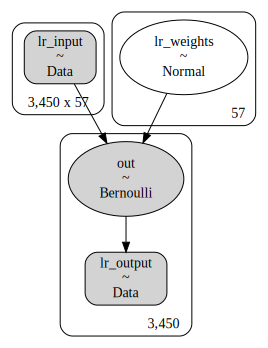

In [19]:
log_model = create_model(X_train, y_train)
pm.model_graph.model_to_graphviz(model=log_model)

In [20]:
with log_model:
    trace = pm.sample(500, tune=500, init="adapt_diag")

/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 95 seconds.


In [21]:
def get_colindex(col):
    return np.where(X_train_raw.columns.values == col)[0][0]

<AxesSubplot: >

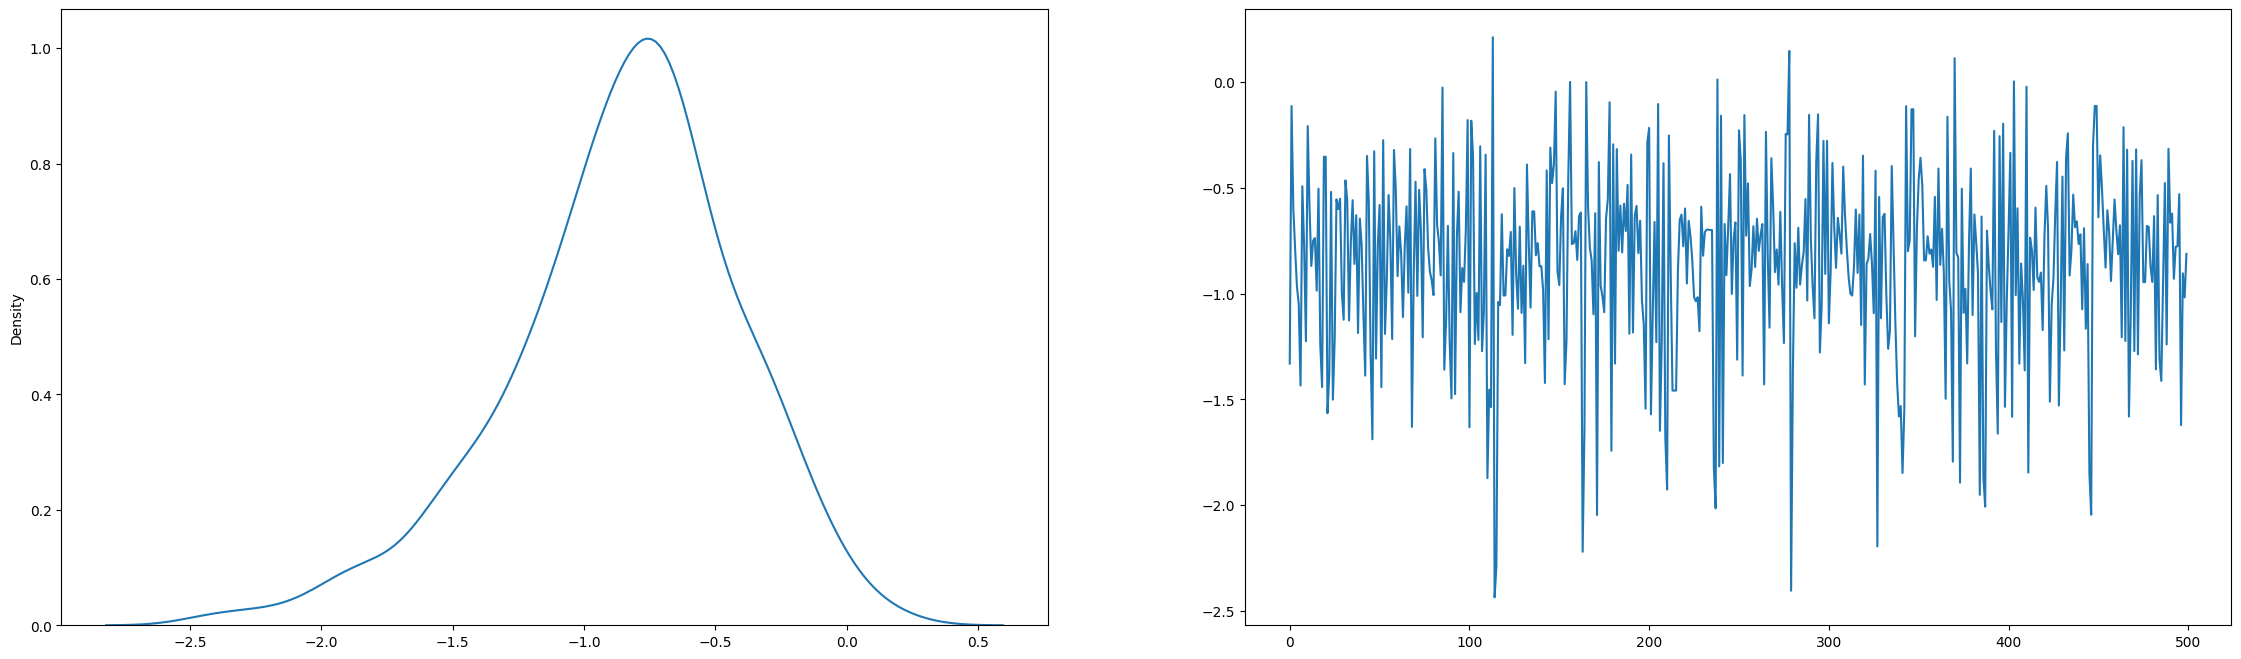

In [22]:
subtrace = np.array([t['lr_weights'][get_colindex('word_freq_data')] for t in trace])
fig, axs = plt.subplots(1, 2, figsize=(28, 8))
sns.kdeplot(subtrace, ax=axs[0])
sns.lineplot(subtrace, ax=axs[1])

In [23]:
with log_model:
    tracesum = az.summary(trace)

In [24]:
tracesum.index = X_train_raw.columns
tracesum.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
word_freq_make,0.535,0.941,-1.177,2.291,0.021,0.017,2067.0,1385.0,1.00
word_freq_address,0.728,0.956,-0.930,2.668,0.019,0.018,2452.0,1214.0,1.00
word_freq_all,2.557,0.813,1.060,4.082,0.019,0.014,1759.0,1364.0,1.01
word_freq_3d,-0.453,0.221,-0.856,-0.029,0.005,0.004,1660.0,1348.0,1.00
word_freq_our,-0.239,0.073,-0.383,-0.115,0.002,0.001,1953.0,1207.0,1.01


## 4. Generating noisy datasets

In [4]:
def create_model(X_train, y_train):
    with pm.Model() as log_model:
        lr_input = pm.Data("lr_input", X_train)
        lr_output = pm.Data("lr_output", y_train)

        # Weights from input to output
        lr_weights = pm.Normal(
            "lr_weights",
            0,
            sigma=1,
            shape=(X_train.shape[1],),
            testval=np.random.randn(X_train.shape[1]).astype(float)
        )

        # Build logistic model using sigmoid activation function
        act_out = pm.math.sigmoid(pm.math.dot(lr_input, lr_weights))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=lr_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
        )
    return log_model

def generate_dataset(
    X, y, test_split=0.4, random_state=42,
    noise_type=None,
    noise_amt=0.0
):
    # generate base splits
    scaler = ColumnTransformer([('minmax-scaler', 
                                 MinMaxScaler(),
                                 ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']
                                )], remainder='passthrough')

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X,
        y,
        random_state=random_state)
    X_train = scaler.fit_transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)
    
    # noise as necessary
    if noise_type is None:
        return X_train, X_test, y_train, y_test

    rng = np.random.default_rng(random_state)
    randmask = rng.random(y_train.shape)
    
    if noise_type == 'uniform':
        # x% of datapoints will have their label flipped, regardless of label.
        y_train[randmask < noise_amt] = 1 - y_train[randmask < noise_amt]
    elif noise_type == 'pu':
        # x% of positives will have their label flipped. Negatives will be untouched.
        y_train[randmask < noise_amt] = 0
        
    return X_train, X_test, y_train, y_test

## 5. Running the model on various things

In [5]:
from scipy.stats import kstest

In [6]:
def transform_trace_to_array(trace, cols):
    arr = np.vstack([t['lr_weights'] for t in trace])
    df = pd.DataFrame(arr, columns=cols)
    return df

In [12]:
features = [x for x in df.columns if x != 'spam']

In [15]:
noise_space_pu = [0., 0.05, 0.1, 0.2, 0.3, 0.4]

tracesums = []
traces = []
models = []
y_tests = []
raw_traces = []
ppcs = []

for n in noise_space_pu:
    random_seed = 30

    # generate splits
    
    print(f'running for PU noise = {n}...')
    X_train, X_test, y_train, y_test = generate_dataset(df[[x for x in df.columns if x != 'spam']], df['spam'], random_state=random_seed,
                                                       noise_type='pu', noise_amt=n)
    
    model = create_model(X_train, y_train)
    
    # training
    
    with model:
        trace = pm.sample(500, tune=500, init="adapt_diag", random_seed=random_seed)
        tracesum = az.summary(trace)

    tracesum.index = features
    traces.append(transform_trace_to_array(trace, features))
    tracesums.append(tracesum)
    raw_traces.append(trace)
    
    # inference
    
    with model:
        model['lr_input'].set_value(X_test)
        ppc = pm.sample_posterior_predictive(trace,
                                             model=model,
                                             samples=100)
    
    ppcs.append(ppc)
    y_tests.append(y_test)
    models.append(model)

running for PU noise = 0.0...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


running for PU noise = 0.05...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 91 seconds.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


running for PU noise = 0.1...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 84 seconds.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


running for PU noise = 0.2...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 101 seconds.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


running for PU noise = 0.3...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 127 seconds.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


running for PU noise = 0.4...


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr_weights]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 103 seconds.
/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [14]:
%debug

> /tmp/ipykernel_2054/1778058346.py(36)<module>()
     34     with model:
     35         model['lr_input'].set_value(X_test)
---> 36         ppc = pm.sample_ppc(trace,
     37                             model=model,
     38                             samples=100)



ipdb>  ppc = pm.sample_posterior_predictive(trace, model=model, samples=100, random_seed=30)


/home/franciszacdlc/.pyenv/versions/3.9.14/envs/base3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


ipdb>  ppc


{'out': array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0]])}


ipdb>  ppc.keys


<built-in method keys of dict object at 0x7fc5757cde40>


ipdb>  ppc.keys()


dict_keys(['out'])


ipdb>  ppc['out'].shape


(100, 1151)


ipdb>  ppc['out'].mean(axis=0).shape


(1151,)


ipdb>  (ppc['out'].mean(axis=0) == y_test).mean()


0.35534317984361424


ipdb>  ppc['out'].mean(axis=0)


array([0.56, 0.  , 0.98, ..., 0.  , 0.42, 0.  ])


ipdb>  from sklearn.metrics import roc_auc_score
ipdb>  roc_auc_score(y_test, ppc['out'].mean(axis=0))


0.9703539765866636


ipdb>  exit


In [16]:
tracesums[0].head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
word_freq_make,0.721,0.949,-0.977,2.587,0.021,0.019,1982.0,1346.0,1.00
word_freq_address,0.686,0.949,-1.068,2.427,0.021,0.019,2041.0,1427.0,1.00
word_freq_all,2.211,0.788,0.736,3.743,0.017,0.013,2031.0,1343.0,1.00
word_freq_3d,-0.389,0.212,-0.792,-0.014,0.005,0.004,1796.0,1510.0,1.00
word_freq_our,-0.241,0.073,-0.383,-0.114,0.002,0.002,1592.0,824.0,1.01


In [17]:
# checking std of the things

chosen_features = ['word_freq_labs', 'word_freq_table', 'word_freq_addresses', 'word_freq_direct', 'word_freq_all', 'capital_run_length_longest']

def generate_tracesumm_plot(features, noise_amts, tracesums, title, v='sd'):
    dff = {}
    for f in features:
        dff[f] = [x.loc[f, v] for x in tracesums]
    df = pd.DataFrame.from_dict(dff)
    df.index = noise_amts
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(df, markers=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('noise ratio')
    ax.set_ylabel(v)
    return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Std of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='sd'>)

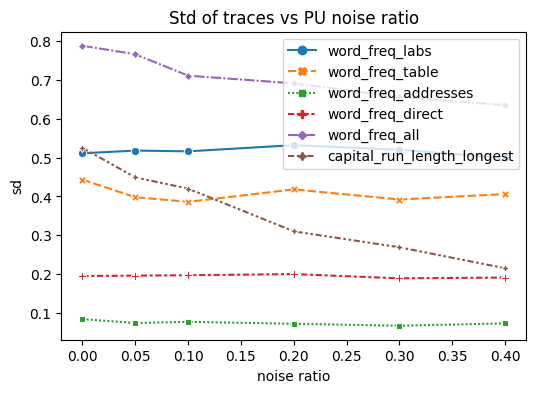

In [18]:
generate_tracesumm_plot(chosen_features, noise_space_pu, tracesums, 'Std of traces vs PU noise ratio')

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Mean of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='mean'>)

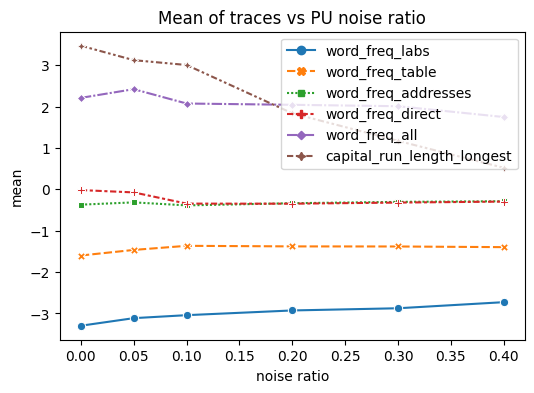

In [19]:
generate_tracesumm_plot(chosen_features, noise_space_pu, tracesums, 'Mean of traces vs PU noise ratio', v='mean')

In [35]:
tracesums[0].sort_values(by='sd', ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
word_freq_address,0.701,0.988,-1.148,2.488,0.022,0.020,2043.0,1552.0,1.00
word_freq_1999,-0.586,0.945,-2.299,1.339,0.021,0.021,1976.0,1291.0,1.00
word_freq_make,0.681,0.927,-1.043,2.374,0.021,0.019,1915.0,1542.0,1.00
word_freq_85,-0.070,0.915,-1.661,1.775,0.021,0.026,1995.0,1206.0,1.00
word_freq_all,2.175,0.782,0.700,3.622,0.018,0.013,1956.0,1288.0,1.01


(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Std of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='sd'>)

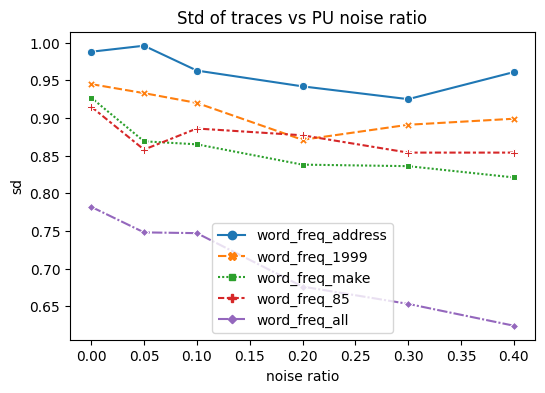

In [36]:
generate_tracesumm_plot(tracesums[0].sort_values(by='sd', ascending=False).head().index.values, noise_space_pu, tracesums, 'Std of traces vs PU noise ratio')

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Mean of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='mean'>)

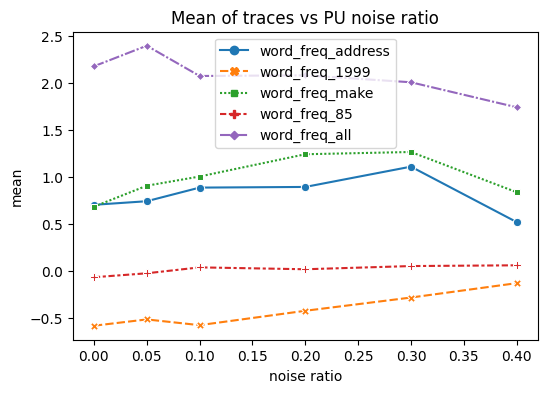

In [37]:
generate_tracesumm_plot(tracesums[0].sort_values(by='sd', ascending=False).head().index.values, noise_space_pu, tracesums, 'Mean of traces vs PU noise ratio', v='mean')

In [38]:
# checking std of the things

def generate_kstest_plot(features, noise_amts, traces, title):
    dff = {}
    for f in features:
        dff[f] = [kstest(x[f], 'norm').pvalue for x in traces]
    df = pd.DataFrame.from_dict(dff)
    df.index = noise_amts

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(df, markers=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('noise ratio')
    ax.set_ylabel('KS test p-value')
    return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'KS normality of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='KS test p-value'>)

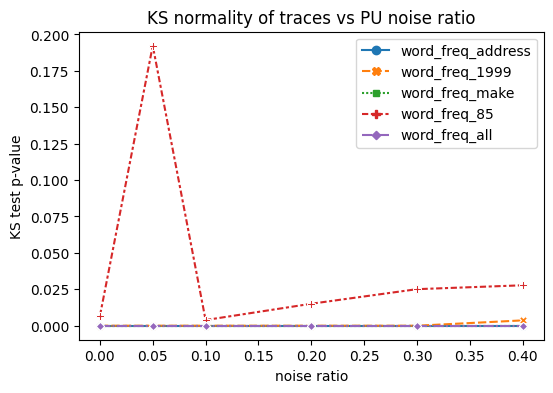

In [39]:
generate_kstest_plot(tracesums[0].sort_values(by='sd', ascending=False).head().index.values, noise_space_pu, traces, 'KS normality of traces vs PU noise ratio')

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'KS normality of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='KS test p-value'>)

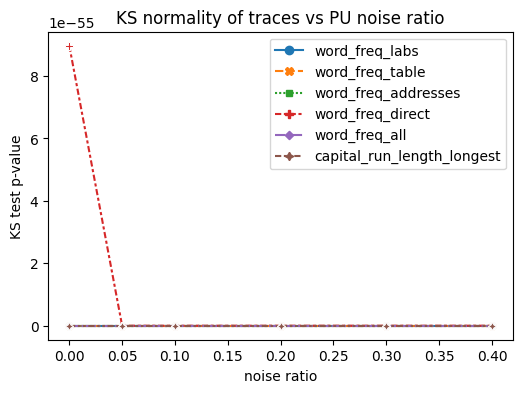

In [40]:
generate_kstest_plot(chosen_features, noise_space_pu, traces, 'KS normality of traces vs PU noise ratio')

In [41]:
# checking std of the things

from scipy.stats import anderson

def generate_anderson_plot(features, noise_amts, traces, title):
    dff = {}
    for f in features:
        dff[f] = [anderson(x[f], 'norm').statistic for x in traces]
    df = pd.DataFrame.from_dict(dff)
    df.index = noise_amts

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(df, markers=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('noise ratio')
    ax.set_ylabel('Anderson test statistic')
    return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Anderson statistic of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='Anderson test statistic'>)

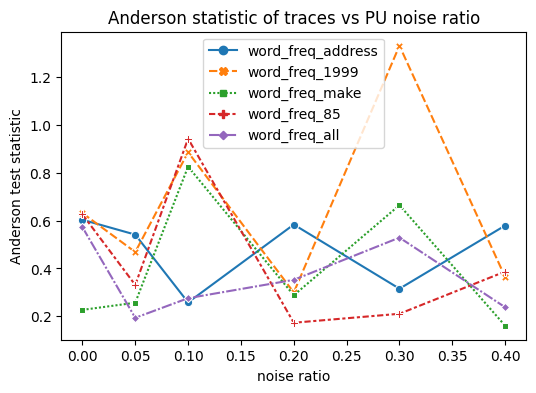

In [42]:
generate_anderson_plot(tracesums[0].sort_values(by='sd', ascending=False).head().index.values, noise_space_pu, traces, 'Anderson statistic of traces vs PU noise ratio')

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Anderson statistic of traces vs PU noise ratio'}, xlabel='noise ratio', ylabel='Anderson test statistic'>)

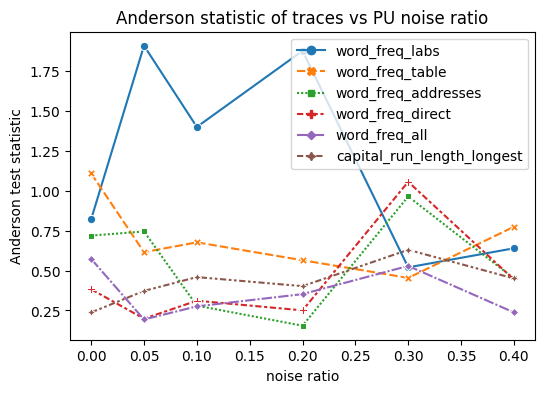

In [43]:
generate_anderson_plot(chosen_features, noise_space_pu, traces, 'Anderson statistic of traces vs PU noise ratio')

## Checking predictions

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [28]:
ppcs[0]['out'].mean(axis=0).shape

(1151,)

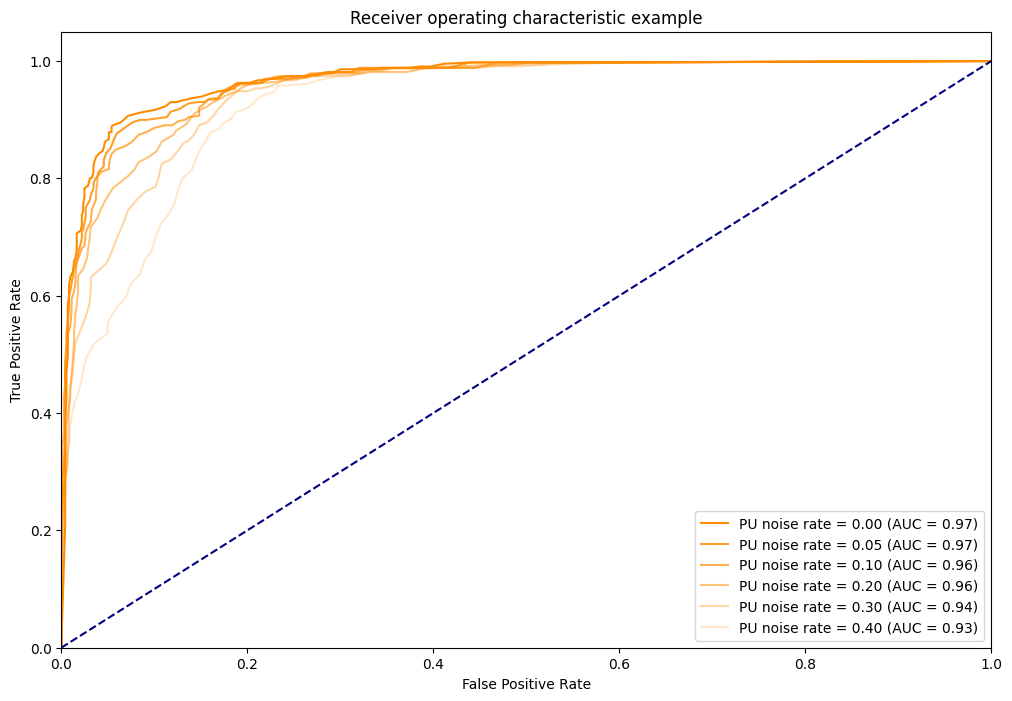

In [32]:
# y_tests = []
# ppcs = []

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(ppcs)):
    y_score = ppcs[i]['out'].mean(axis=0)
    y_test = y_tests[i]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        color="darkorange",
        alpha=1-(0.16 * i),
        label="PU noise rate = {:.2f} (AUC = {:.2f})".format(noise_space_pu[i], roc_auc)
    )

ax.plot([0, 1], [0, 1], color="navy", linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic example")
ax.legend(loc="lower right")

fig.show()